In [1]:
!pip install tensorflow opencv-python matplotlib

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2

In [ ]:
!wget --no-check-certificate 'https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip'
!unzip -q data_road.zip

--2025-07-24 14:10:10--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.140.63, 52.219.171.85, 3.5.134.27, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.140.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 470992343 (449M) [application/zip]
Saving to: ‘data_road.zip’

data_road.zip        93%[=================>  ] 420.02M   765KB/s    eta 4s     

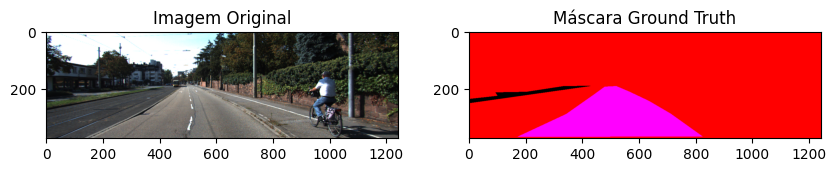

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Caminhos das pastas do dataset (ajuste se necessário)
img_dir = 'data_road/training/image_2'
mask_dir = 'data_road/training/gt_image_2'

# Escolha um nome de arquivo (ajuste conforme necessário)
img_name = 'um_000000.png'
mask_name = 'um_road_000000.png'

# Carregar imagem e máscara originais
img = Image.open(os.path.join(img_dir, img_name))
mask = Image.open(os.path.join(mask_dir, mask_name))

# Exibir lado a lado
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Imagem Original')

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title('Máscara Ground Truth')

plt.show()


In [5]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

def find_corresponding_mask(img_file, gt_dir):
    """
    Encontra o arquivo de máscara correspondente para uma imagem no KITTI Road Dataset
    """
    base_name = os.path.splitext(img_file)[0]

    # Tentar os padrões de nome encontrados no dataset
    patterns = [
        f"{base_name}_road.png",  # Para imagens 'um_000000.png'
        f"um_lane_{base_name.split('_')[-1]}.png",  # Para imagens 'um_000000.png'
        f"umm_road_{base_name.split('_')[-1]}.png",  # Para imagens 'umm_000000.png'
        f"uu_road_{base_name.split('_')[-1]}.png",   # Para imagens 'uu_000000.png'
        f"{base_name}.png"  # Último recurso
    ]

    for pattern in patterns:
        mask_path = os.path.join(gt_dir, pattern)
        if os.path.exists(mask_path):
            return mask_path
    return None

def load_kitti_data(base_path, img_size=(512, 512)):
    """
    Carrega corretamente o dataset KITTI Road com seus padrões de nome específicos
    """
    image_dir = os.path.join(base_path, 'training', 'image_2')
    gt_dir = os.path.join(base_path, 'training', 'gt_image_2')

    images = []
    masks = []

    # Listar todas as imagens
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

    print(f"Encontradas {len(image_files)} imagens no diretório")

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mask_path = find_corresponding_mask(img_file, gt_dir)

        if mask_path is None:
            print(f"Aviso: Máscara não encontrada para {img_file}, pulando...")
            continue

        # Carregar e pré-processar imagem
        img = Image.open(img_path).resize(img_size)
        img_array = np.array(img) / 255.0

        # Carregar e pré-processar máscara
        mask = Image.open(mask_path).resize(img_size)
        mask_array = np.array(mask)


        mask_array = np.array(mask)
        lower = np.array([200, 0, 200])
        upper = np.array([255, 20, 255])
        road_mask = cv2.inRange(mask_array, lower, upper) / 255.0
        road_mask = np.expand_dims(road_mask, axis=-1)


        images.append(img_array)
        masks.append(road_mask)

    if len(images) == 0:
        raise ValueError(
            "Nenhuma imagem válida foi carregada. Verifique:\n"
            "1. Os padrões de nomes de arquivos\n"
            "2. O conteúdo das pastas image_2 e gt_image_2\n"
            f"Exemplo de arquivo em image_2: {os.listdir(image_dir)[0]}\n"
            f"Exemplo de arquivo em gt_image_2: {os.listdir(gt_dir)[0]}"
        )

    return np.array(images), np.array(masks)

# Verificar estrutura de arquivos
print("Exemplo de arquivos em image_2:")
!ls data_road/training/image_2/ | head -5
print("\nExemplo de arquivos em gt_image_2:")
!ls data_road/training/gt_image_2/ | head -5

# Carregar dados corretamente
try:
    X, y = load_kitti_data('data_road')
    print(f"\nDataset carregado com sucesso! Formato: X={X.shape}, y={y.shape}")

    # Dividir em treino e validação
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Dados divididos: Treino={X_train.shape}, Validação={X_val.shape}")

except Exception as e:
    print(f"\nErro ao carregar dados: {str(e)}")
    print("\nPara diagnóstico, execute:")
    print("!ls -R data_road/training/")

Exemplo de arquivos em image_2:
um_000000.png
um_000001.png
um_000002.png
um_000003.png
um_000004.png

Exemplo de arquivos em gt_image_2:
um_lane_000000.png
um_lane_000001.png
um_lane_000002.png
um_lane_000003.png
um_lane_000004.png
Encontradas 289 imagens no diretório

Dataset carregado com sucesso! Formato: X=(289, 512, 512, 3), y=(289, 512, 512, 1)
Dados divididos: Treino=(231, 512, 512, 3), Validação=(58, 512, 512, 3)


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50

class ASPP(layers.Layer):
    def __init__(self, filters=256, **kwargs):
        super(ASPP, self).__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        self.conv1 = layers.Conv2D(self.filters, 1, padding='same', kernel_initializer='he_normal')
        self.conv2 = layers.Conv2D(self.filters, 3, dilation_rate=6, padding='same', kernel_initializer='he_normal')
        self.conv3 = layers.Conv2D(self.filters, 3, dilation_rate=12, padding='same', kernel_initializer='he_normal')
        self.conv4 = layers.Conv2D(self.filters, 3, dilation_rate=18, padding='same', kernel_initializer='he_normal')
        self.conv_final = layers.Conv2D(self.filters, 1, padding='same', kernel_initializer='he_normal')
        self.bns = [layers.BatchNormalization() for _ in range(5)]
        super(ASPP, self).build(input_shape)

    def call(self, inputs):
        # Pooling branch
        pool = tf.keras.backend.mean(inputs, axis=[1,2], keepdims=True)
        pool = self.conv1(pool)
        pool = self.bns[0](pool)
        pool = tf.nn.relu(pool)
        pool = tf.image.resize(pool, size=tf.shape(inputs)[1:3])

        # Convolution branches
        conv1 = self.conv1(inputs)
        conv1 = self.bns[1](conv1)
        conv1 = tf.nn.relu(conv1)

        conv2 = self.conv2(inputs)
        conv2 = self.bns[2](conv2)
        conv2 = tf.nn.relu(conv2)

        conv3 = self.conv3(inputs)
        conv3 = self.bns[3](conv3)
        conv3 = tf.nn.relu(conv3)

        conv4 = self.conv4(inputs)
        conv4 = self.bns[4](conv4)
        conv4 = tf.nn.relu(conv4)

        # Concatenate all branches
        x = layers.Concatenate(axis=-1)([pool, conv1, conv2, conv3, conv4])
        x = self.conv_final(x)
        return x

def DeeplabV3Plus(input_shape=(256, 256, 3), num_classes=1):

    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Backbone - ResNet50
    backbone = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    # Get feature maps from backbone
    skip_connection = backbone.get_layer('conv2_block3_2_relu').output
    x = backbone.get_layer('conv4_block6_2_relu').output

    # ASPP Module
    x = ASPP(filters=256)(x)

    # Decoder
    x = layers.UpSampling2D(size=(input_shape[0]//4//x.shape[1], input_shape[1]//4//x.shape[2]),
                          interpolation='bilinear')(x)

    # Skip connection
    skip = layers.Conv2D(48, 1, padding='same', kernel_initializer='he_normal')(skip_connection)
    skip = layers.BatchNormalization()(skip)
    skip = layers.Activation('relu')(skip)

    x = layers.Concatenate()([x, skip])

    # Additional convolutions
    x = layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    # Final upsampling and output
    x = layers.UpSampling2D(size=(input_shape[0]//x.shape[1], input_shape[1]//x.shape[2]),
                           interpolation='bilinear')(x)
    outputs = layers.Conv2D(num_classes, 1, padding='same', activation='sigmoid')(x)

    return Model(inputs=inputs, outputs=outputs)

# Criar e compilar o modelo
model = DeeplabV3Plus(input_shape=(512, 512, 3), num_classes=1)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.MeanIoU(num_classes=2)
    ]
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 518, 518,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 256, 256,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 256, 256,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 256, 256,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 258, 258,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 128, 128,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 128, 128,  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 128, 128,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 128, 128,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 128, 128,  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 128, 128,  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 128, 128,  │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 128, 128,  │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 128, 128,  │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 128, 128,  │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 128, 128,  │      1,024 │ conv2_block1_3_c

 Total params: 11,787,377 (44.97 MB)

 Trainable params: 11,755,153 (44.84 MB)

 Non-trainable params: 32,224 (125.88 KB)

In [10]:
# Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min'
    ),
    #tf.keras.callbacks.EarlyStopping(
    #  monitor='val_loss',
    #   patience=10,
    #   restore_best_weights=True
    #),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        min_lr=1e-6
    )
]


from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2]
)


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=100,
    callbacks=callbacks
)



Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - binary_accuracy: 0.9946 - loss: 0.0555 - mean_io_u: 0.8663 - precision: 0.9678 - recall: 0.9637

29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 503ms/step - binary_accuracy: 0.9946 - loss: 0.0555 - mean_io_u: 0.8663 - precision: 0.9679 - recall: 0.9637 - val_binary_accuracy: 0.9704 - val_loss: 0.1217 - val_mean_io_u: 0.5340 - val_precision: 0.9086 - val_recall: 0.6979 - learning_rate: 1.0000e-06
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 463ms/step - binary_accuracy: 0.9946 - loss: 0.0522 - mean_io_u: 0.8655 - precision: 0.9678 - recall: 0.9665 - val_binary_accuracy: 0.9707 - val_loss: 0.1257 - val_mean_io_u: 0.5561 - val_precision: 0.8966 - val_recall: 0.7138 - learning_rate: 1.0000e-06
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 464ms/step - binary_accuracy: 0.9948 - loss: 0.0513 - mean_io_u: 0.8733 - precision: 0.9671 - recall: 0.9692 - val_binary_accuracy: 0.9710 - val_loss: 0.1264 - val_mean_io_u: 0.5686 - val_precision: 0.8927 - val_recall: 0.7221 - learning_rate: 1.0000e-06
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 460ms/step - binary_accuracy: 0.9948 - loss: 0.0521 - mean_io_u: 0.8679 - p

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━

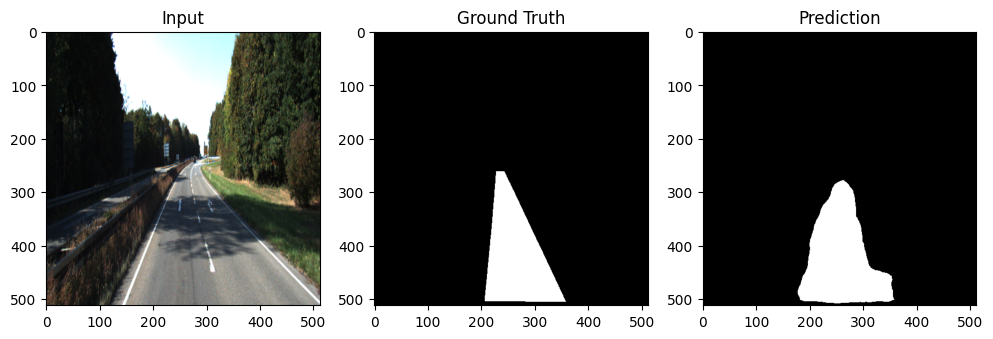

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Imagem 1 → IoU: 0.9058 | Dice: 0.9506


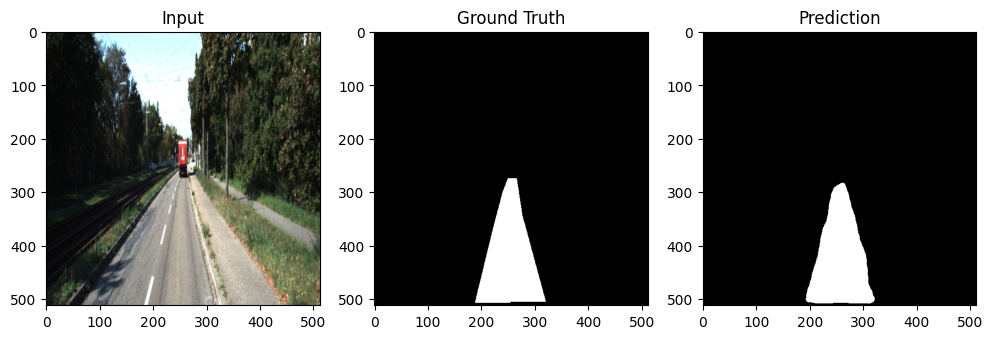

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Imagem 2 → IoU: 0.6357 | Dice: 0.7773


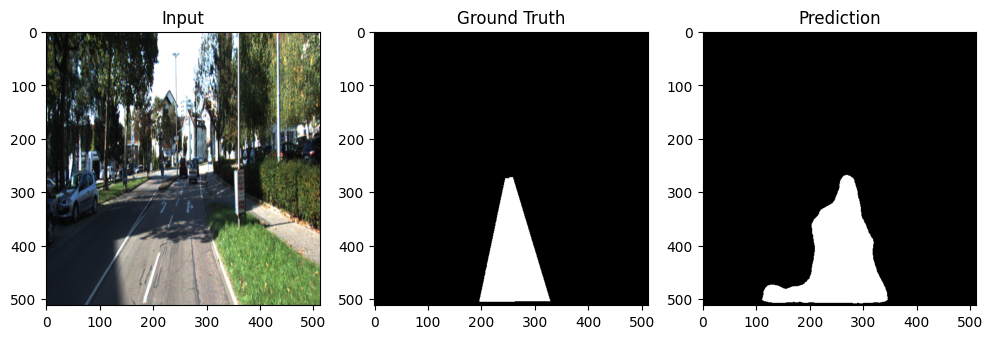

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Imagem 3 → IoU: 0.8956 | Dice: 0.9449


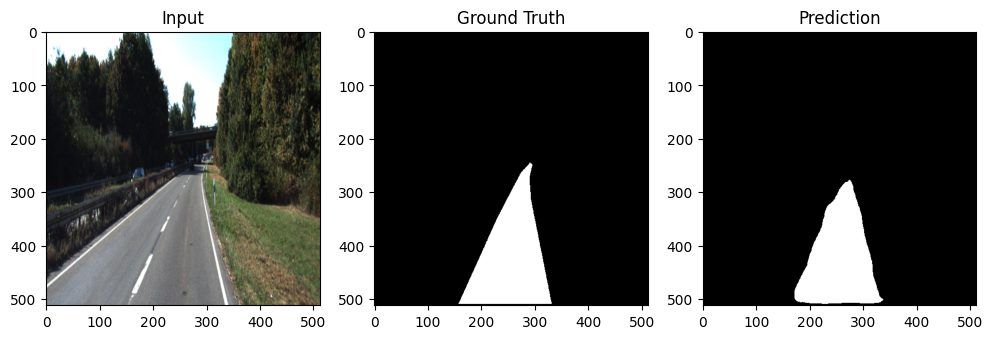

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Imagem 4 → IoU: 0.8794 | Dice: 0.9358


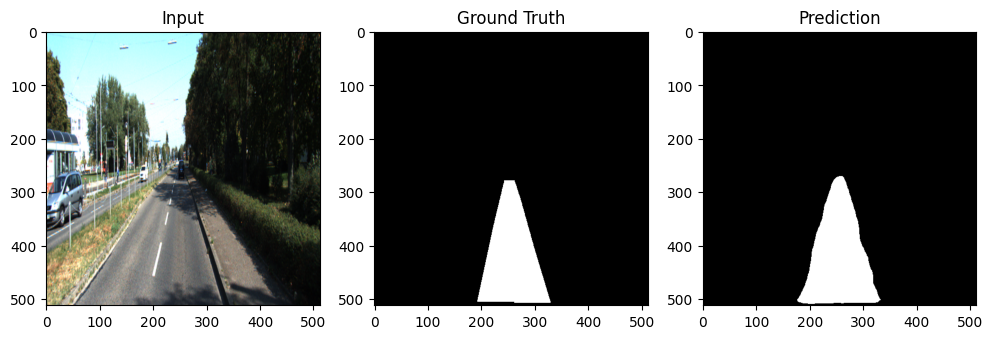

In [11]:

# === Cálculo das métricas IoU e Dice ===

def compute_iou(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.uint8)
    y_true = y_true.astype(np.uint8)

    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()

    if union == 0:
        return 1.0 if intersection == 0 else 0.0
    return intersection / union

def compute_dice(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.uint8)
    y_true = y_true.astype(np.uint8)

    intersection = np.logical_and(y_true, y_pred).sum()
    total = y_true.sum() + y_pred.sum()

    if total == 0:
        return 1.0 if intersection == 0 else 0.0
    return 2. * intersection / total

# Avaliar o modelo no conjunto de validação
ious = []
dices = []

for i in range(len(X_val)):
    y_true = y_val[i].squeeze()
    y_pred = model.predict(X_val[i:i+1]).squeeze()

    iou = compute_iou(y_true, y_pred)
    dice = compute_dice(y_true, y_pred)

    ious.append(iou)
    dices.append(dice)

# Mostrar resultados
mean_iou = np.mean(ious)
mean_dice = np.mean(dices)

print(f"\n📈 IoU médio no conjunto de validação: {mean_iou:.4f}")
print(f"🎯 Dice Coefficient médio: {mean_dice:.4f}")


import matplotlib.pyplot as plt

def plot_prediction(idx):
    plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(X_val[idx])
    plt.title("Input")
    plt.subplot(132)
    plt.imshow(y_val[idx].squeeze(), cmap='gray')
    plt.title("Ground Truth")

    pred = model.predict(X_val[idx:idx+1]).squeeze()
    plt.subplot(133)
    plt.imshow(pred > 0.5, cmap='gray')
    plt.title("Prediction")

    # Mostrar métricas
    iou = compute_iou(y_val[idx].squeeze(), pred)
    dice = compute_dice(y_val[idx].squeeze(), pred)
    print(f"Imagem {idx} → IoU: {iou:.4f} | Dice: {dice:.4f}")

    plt.show()

for i in range(5):
    plot_prediction(i)



IoU
Dice

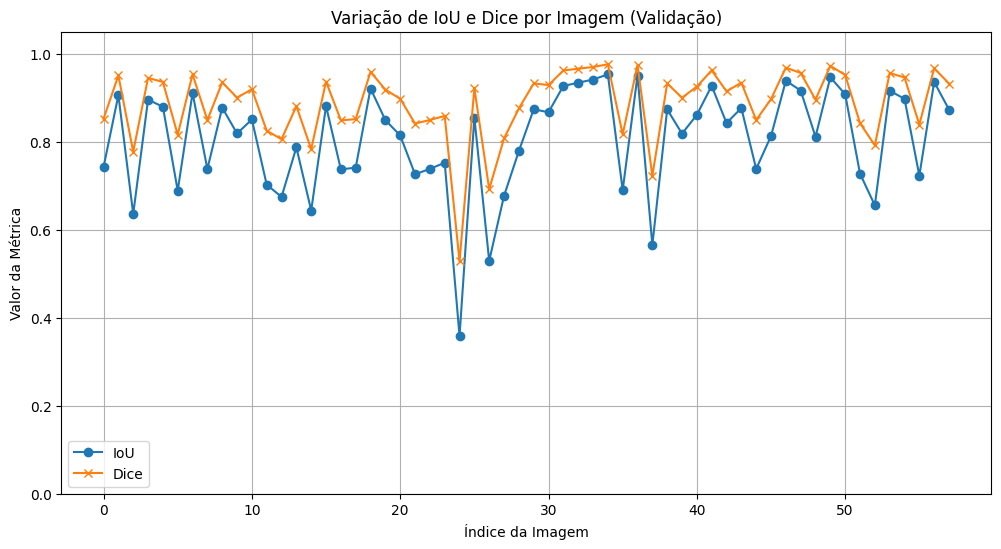

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(ious, label='IoU', marker='o')
plt.plot(dices, label='Dice', marker='x')
plt.title('Variação de IoU e Dice por Imagem (Validação)')
plt.xlabel('Índice da Imagem')
plt.ylabel('Valor da Métrica')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


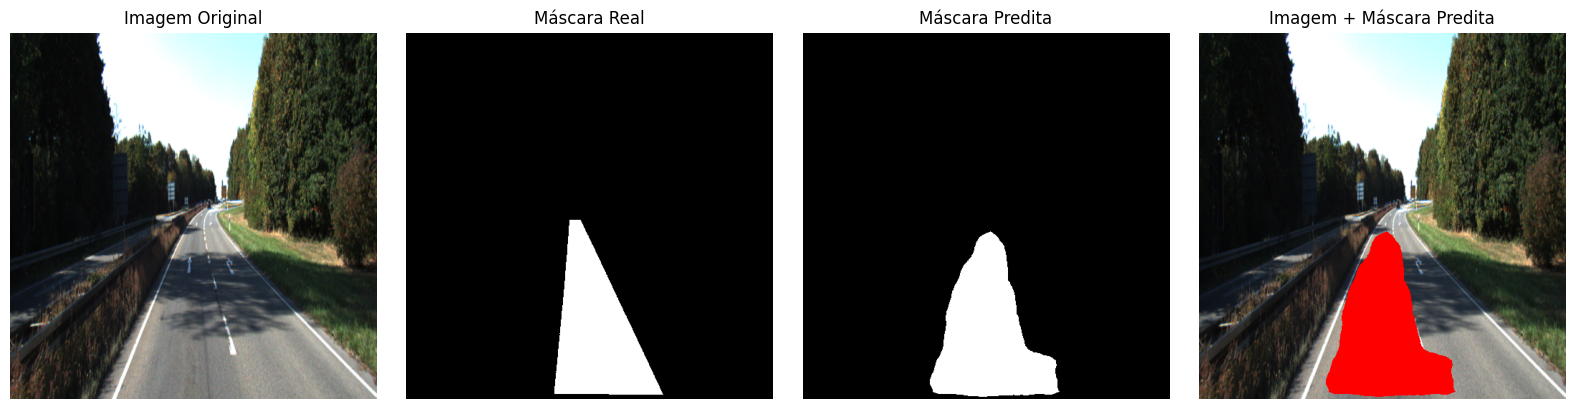

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


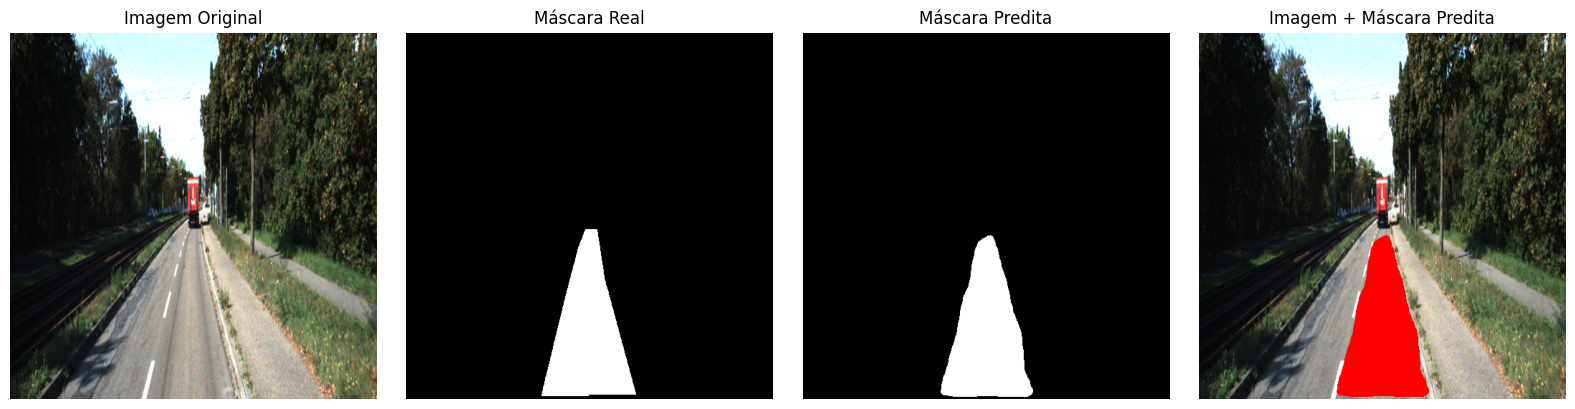

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


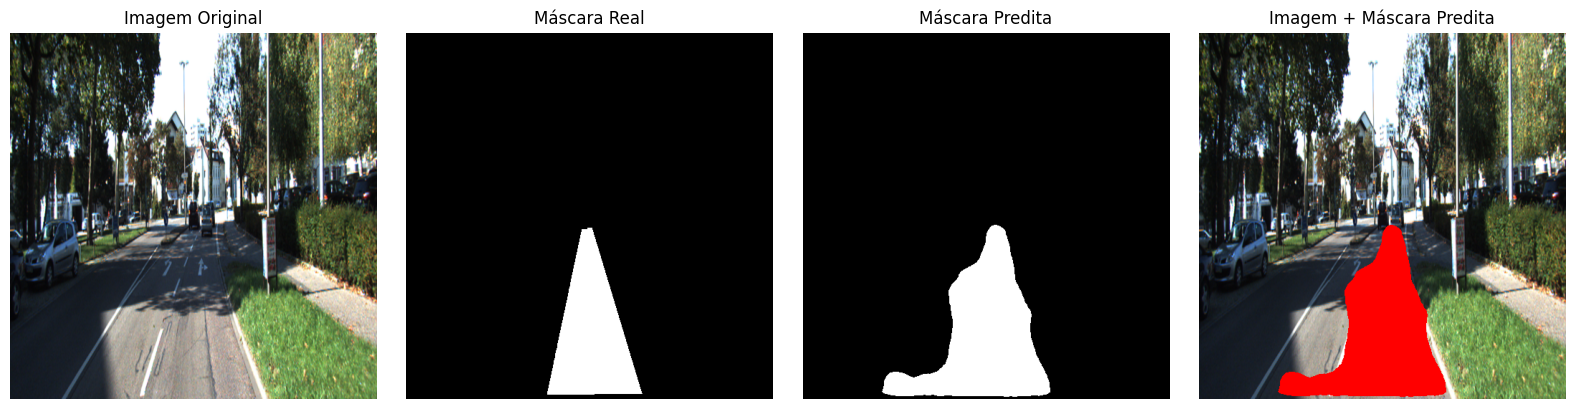

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


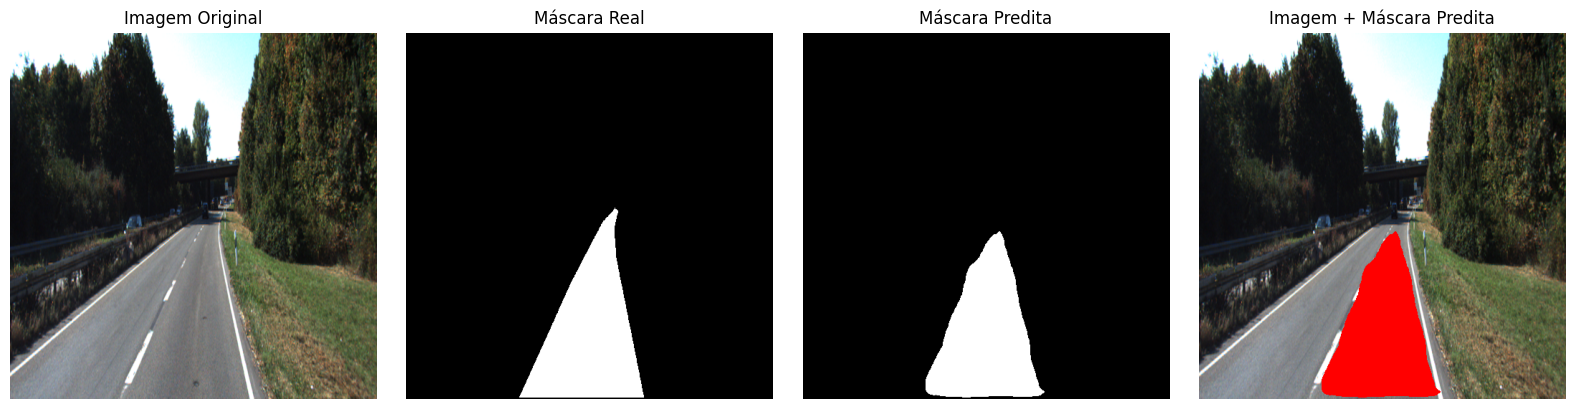

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


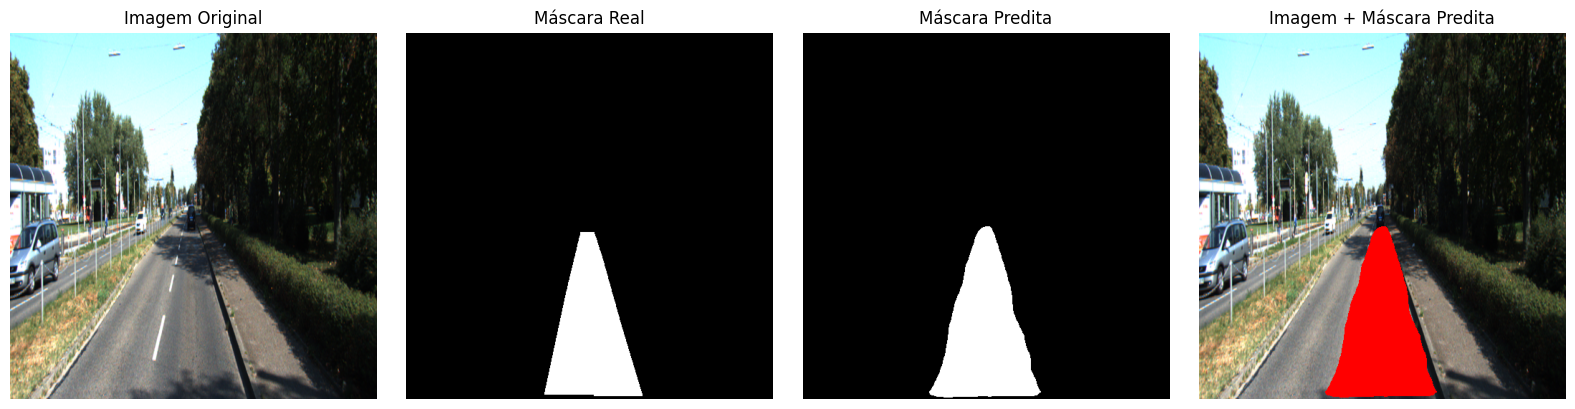

In [14]:
import matplotlib.pyplot as plt
import numpy as np

num_visual = 5  # Número de imagens a exibir

for idx in range(num_visual):
    image = X_val[idx]
    true_mask = y_val[idx].squeeze()

    pred = model.predict(np.expand_dims(image, axis=0))[0, :, :, 0]
    pred_mask = (pred > 0.5).astype(np.uint8)

    # Visualização
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.imshow((image * 255).astype(np.uint8))
    plt.title("Imagem Original")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("Máscara Real")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Máscara Predita")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    # Sobreposição da predição na imagem original
    overlay = (image * 255).astype(np.uint8).copy()
    overlay[pred_mask == 1] = [255, 0, 0]  # Máscara predita em vermelho
    plt.imshow(overlay)
    plt.title("Imagem + Máscara Predita")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
